In [1]:
%%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
import collections
import scipy.signal
import functools
from IPython.display import HTML, display
from tqdm import tqdm
import sklearn.metrics
import hdbscan
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

seed_number_range = []     
for num in range(1):
    seed_number_range.append(f'Paper_all_and_eyeblink')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 4
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0,5,10,15,20,25,50,100,800]

parameters_value = { "range_plasticity": ['Plasticity'], "range_after_plasticity": ['after_Plasticity'],
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}

Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

@functools.lru_cache
def load_io_vs(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    IO_output = output_load_run('IO',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(IO_output['Vs']/mV)

@functools.lru_cache
def load_io_spikes(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    o = output_load_run('IO_spikes','_Coupled' if coupling else '',seed_number,
                           p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)

    x = []
    for i in range(N_Cells_IO):
        x.append(o[str(i)])
    return x

class Case(collections.abc.Mapping):
    def __init__(self, **kw):
        self.kw = kw
        for k in kw:
            assert k in ['coupling', 'zebrin', 'plasticity']
    def __len__(self):
        return 1
    def __getitem__(self, k):
        return self.kw[k]
    def __iter__(self):
        return iter(self.kw)
    def __eq__(self, other):
        for k in ['coupling', 'zebrin', 'plasticity']:
            if self.kw.get(k, '*') !=  other.kw.get(k, '*'):
                return False
        return True
    def __hash__(self):
        return __builtins__.sum(hash(f'{k}{self.kw.get(k, "*")}') for k in ['coupling', 'zebrin', 'plasticity'])
    @property
    def before(self):
        kw = dict(self.kw)
        kw['plasticity'] = False
        return Case(**kw)
    @property
    def after(self):
        kw = dict(self.kw)
        kw['plasticity'] = True
        return Case(**kw)
    @property
    def during(self):
        kw = dict(self.kw)
        kw['plasticity'] = None
        return Case(**kw)
    def __repr__(self):
        return '/'.join([
            {True: 'C', False: 'U', '*': '*'}[self.kw.get('coupling', '*')],
            {True: 'Z+', False: 'Z-', '*': '*'}[self.kw.get('zebrin', '*')],
            {True: 'AP', False: 'NP', None: 'P', '*': '*'}[self.kw.get('plasticity', '*')]])
        

CP = Case(coupling=True, zebrin=True)
CN = Case(coupling=True, zebrin=False)
UP = Case(coupling=False, zebrin=True)
UN = Case(coupling=False, zebrin=False)

def calc_synchrony(vs, fs=1000, order=5, lp=8, hp=15, lpsync=5):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.exp(1j*np.angle(analytic))
    synchrony = abs(angle.mean(0))
    sos = scipy.signal.butter(order, lpsync, 'lp', fs=fs, output='sos')
    return scipy.signal.sosfiltfilt(sos, synchrony)

def calc_phase(vs, fs=1000, order=5, lp=4, hp=15):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.angle(analytic)
    return angle


WARNING    <timed exec>:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 30.4 s, sys: 9.67 s, total: 40.1 s
Wall time: 47.5 s


# Figure S2-2 - A

[     0    445    454 ... 118542 118742 118926]
[     0    449    455 ... 119144 119689 119900]
CPU times: user 4.28 s, sys: 1.32 s, total: 5.6 s
Wall time: 9.5 s


Text(0.5, 0.98, 'STO synchrony is higher in coupled case and peaks with spikes')

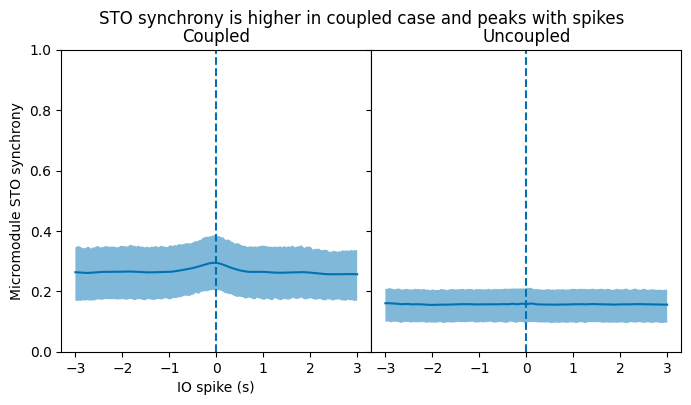

In [2]:
%%time
Winstats = collections.namedtuple('Winstats', 't mean p25 p75 s')
def winstats(idx, x, win):
    t = np.arange(-win, 1+win)
    s = []
    print(idx)
    for i in idx:
        if i >= win and i < len(x)-win:
            s.append(x[i-win:i+win+1])
    return Winstats(
        t = t,
        p25=np.percentile(s, 25, axis=0),
        p75=np.percentile(s, 75, axis=0),
        mean=np.mean(s, axis=0),
        s=s
    )

case1 = CN.after
case2 = UN.after

win=3000


fig, ax = plt.subplots(figsize=(8, 4), ncols=2, gridspec_kw=dict(hspace=0,wspace=0), sharey=True, dpi=100)

vs = load_io_vs(**case1)
synchrony = calc_synchrony(vs, lpsync=2)
ev = np.round(np.concatenate(load_io_spikes(**case1))*1e3).astype(int)
sc = winstats(ev, synchrony, win=win)

vs = load_io_vs(**case2)
synchrony = calc_synchrony(vs)
ev = np.round(np.concatenate(load_io_spikes(**case2))*1e3).astype(int)
su = winstats(ev, synchrony, win=win)


ax[0].set_ylim([0,1])
ax[1].set_ylim([0,1])
ax[0].axvline(0, ls='--')
ax[1].axvline(0, ls='--')
ax[0].set_xlabel('IO spike (s)')
ax[0].set_ylabel('Micromodule STO synchrony')

ax[0].fill_between(sc.t*1e-3, sc.p25, sc.p75, alpha=0.5)
ax[0].plot(sc.t*1e-3, sc.mean)
ax[1].fill_between(su.t*1e-3, su.p25, su.p75, alpha=0.5)
ax[1].plot(su.t*1e-3, su.mean)
ax[0].set_title('Coupled')
ax[1].set_title('Uncoupled')
plt.suptitle('STO synchrony is higher in coupled case and peaks with spikes')
# plt.savefig('svg/uc_c_io_sto.svg')

# Figure S2-2 - B

(119999,)
(119999,)


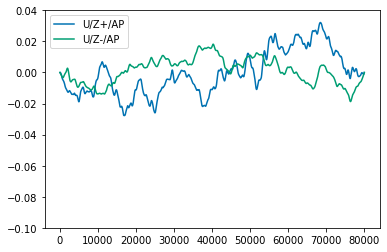

In [3]:
from scipy.signal import savgol_filter
def calc_phase(vs, fs=1000, order=5, lp=4, hp=15):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.angle(analytic)
    return angle

cases = [UP.after, UN.after]
for case in cases:
    v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
    phase = np.unwrap(calc_phase(v, lp=4, hp=8))
    d = np.diff(phase)
    d = d.mean(0)
    d = np.cumsum(d)
    print(d.shape)
    d = savgol_filter(d, 1001, 3)
    d = d[20000:100000]
    d = d - d[0]
    #d = d - np.linspace(0, 80*2*np.pi*5.5, len(d))
    D = d[-1] - d[0]
    d = d - np.linspace(d[0], d[-1], len(d))
    d = d / (100-20)
    plt.plot(d, label=repr(case))
    # plt.plot(np.diff(d[100:-100])*1000/2/np.pi)

#plt.xlim(60000, 70000)
plt.ylim([-.10, .04])
# plt.savefig('svg/globalphase_offset_uc.svg')
plt.legend()


# Figure S2-2 - C

CPU times: user 804 ms, sys: 216 ms, total: 1.02 s
Wall time: 1.02 s


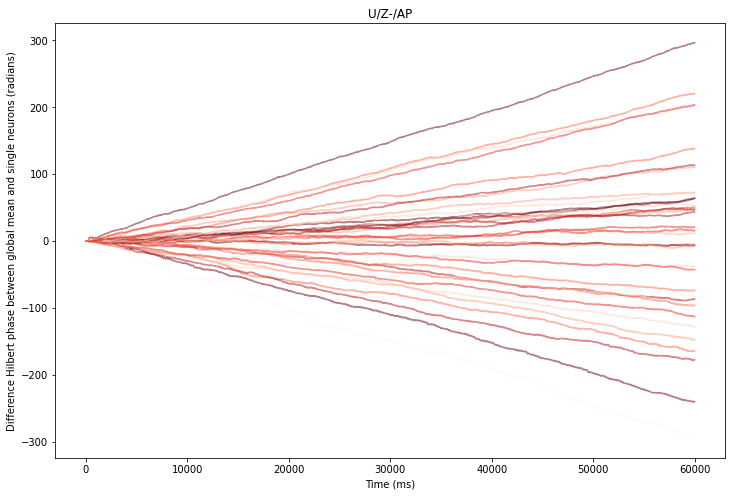

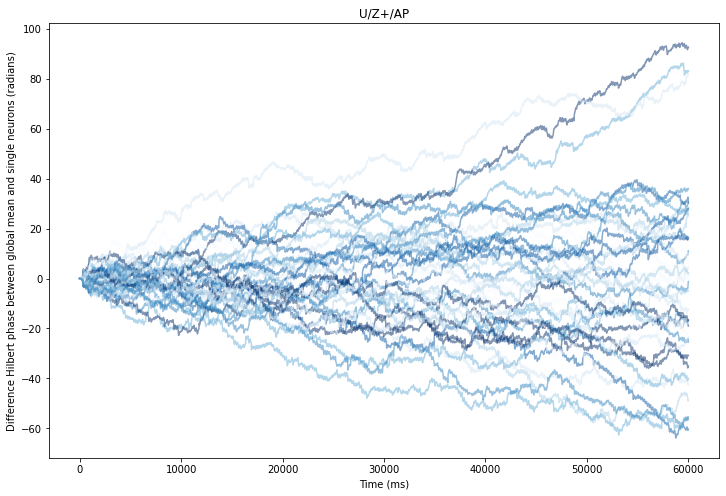

In [4]:
%%time
cases = [UN.after, UP.after]

def wrap(x, n=20):
    x = (x+n*np.pi) % (n * 2 * np.pi) - +n*np.pi
    l = []
    for xx in x:
        xx[abs(np.diff(xx, prepend=xx[0])) > n * np.pi] = float('nan')
        l.append(xx)
    return np.stack(l)

for case in cases:
    plt.figure(figsize=(12, 8))
    plt.title(str(case))
    plt.gca().set_prop_cycle(color=list(plt.get_cmap('Blues' if case['zebrin'] else 'Reds')(np.linspace(0, 1, 7))))
    v = np.array(load_io_vs(**case, f0=0, noise_gain=1))
    phase = calc_phase(v)
    p = np.unwrap(phase).T
    pd = p - p.mean(1)[:,None]
    #base = np.round(p.mean(1) / (2*np.pi)).astype(int) * 2 * np.pi
    #pmean = np.unwrap(np.angle(np.exp(1j*phase).mean(0)))[:,None]
    #pmean = base + np.angle(np.exp(1j*phase).mean(0))
    #pmean = np.unwrap(pmean)
    #pmean = pmean[:,None]
    #pd = p - pmean
    for line in wrap(pd.T, 10000):
        plt.plot(line[:60000], alpha=.5);
    plt.xlabel('Time (ms)')
    plt.ylabel('Difference Hilbert phase between global mean and single neurons (radians)')
#     plt.savefig(f'svg/unc_phasors_{str(case).replace("/", "_")}.svg')
    #print(p.mean(0).shape)
#plt.plot(p)